In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline

from simcodes.fitters import ExtendedLS
from gatspy.periodic import LombScargleMultiband
from KuiperMetric import KuiperVS

In [24]:
# Grab the current baseline file. Should have been downloaded with rubin_sim. 
# Can grab lots of different sims from: http://astro-lsst-01.astro.washington.edu:8081/
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
conn = maf.db.OpsimDatabase(baseline_file)
outDir = 'temp'
resultsDb = maf.db.ResultsDb(outDir=outDir)

In [25]:
baseline_file

'/mnt/Data/Work/Sources/rubin_sim_data/sim_baseline/baseline_v2.0_10yrs.db'

In [33]:
# Same for rolling cadence
rollDbFile = '/mnt/Data/Work/Sources/rubin_sim_data/experiments/rolling_all_sky_ns2_rw0.9_v2.0_10yrs.db'
rollName = os.path.split(rollDbFile)[-1].replace('.db', '')
rollDb = maf.db.OpsimDatabase(rollDbFile)
resultsDbRoll = maf.db.ResultsDb(outDir=outDir)
print(rollName)

rolling_all_sky_ns2_rw0.9_v2.0_10yrs


In [26]:
# Test quality of period determination
### Integrating with period determination
library=pd.read_csv('/mnt/Data/Work/GitHub/KuiperTest_VStemplates/simcodes/ZTF_VS_all_formatted.csv',index_col=0)
library['unique_filts_']=library['unique_filts_'].apply(lambda x:list(map(eval,x[1:-1].split(' '))))
library['ymean_by_filt_']=library['ymean_by_filt_'].apply(lambda x:np.array([float(k) for k in x[1:-1].split(' ') if len(k)>0]))
library['theta']=library['theta'].apply(lambda x:np.array([float(k) for k in x[1:-1].split(' ') if len(k)>0]))

<AxesSubplot:>

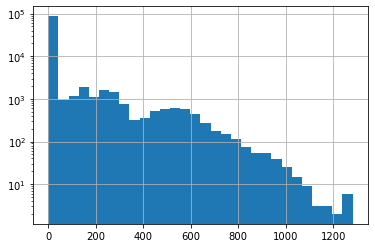

In [32]:
library['_best_period'].hist(bins=30,log=True)

In [36]:
# Set range of periods for which we're gonna build the maps
perStep=100
numPoints=50
totalObsLength=365*5
#periods=np.round(np.linspace(perStep, numPoints*perStep,numPoints,dtype='float'),3) # equal step periods
"""
# Random periods
periods=np.random.rand(numPoints)*totalObsLength
periods=periods.round(2)
"""

#Periods based on the LC library
periods=np.array(library['_best_period'])
periods.sort()

bundleList=[]
bundleListRoll=[]
ra = [0.]
dec = [-20]


for p in periods:
    metric = KuiperVS(period=p)
    sql = ''
    slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
    bundleList.append(maf.MetricBundle(metric, slicer, sql, runName='KuiperVSTest_'+str(p)))
    bundleListRoll.append(maf.MetricBundle(metric, slicer, sql, runName='RollKuiperVSTest_'+str(p)))

In [21]:
bd = maf.metricBundles.makeBundlesDictFromList(bundleList)
bg = maf.metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database observations with no constraint for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'rotSkyPos'].
Found 2086980 visits
Running:  ['KuiperVSTest_14_66_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_31_48_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_52_1_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_243_8_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_252_51_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_262_85_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_319_15_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_334_68_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_355_49_KuiperVS_observationStartMJD_USER']
Completed metric 

In [22]:
bdRoll = maf.metricBundles.makeBundlesDictFromList(bundleListRoll)
bgRoll = maf.metricBundles.MetricBundleGroup(bdRoll, rollDb, outDir=outDir, resultsDb=resultsDbRoll)
bgRoll.runAll()

Querying database observations with no constraint for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'rotSkyPos'].
Found 2088105 visits
Running:  ['RollKuiperVSTest_14_66_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_31_48_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['RollKuiperVSTest_52_1_KuiperVS_observationStartMJD_USER']


KeyboardInterrupt: 

In [ ]:
getResultDict=lambda bList:{float(p.runName.split('_')[1]):p.metricValues.data[0] for p in bList}
periods=getResultDict(bundleList)
periodsRoll=getResultDict(bundleListRoll)

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(15,3))
ax.scatter(periods.keys(),periods.values(),s=2)
ax.scatter(periodsRoll.keys(),periodsRoll.values(),marker='s',s=2)

In [ ]:
metricPass = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth'])
bundleListPass=[]
bundleListPassRoll=[]

bundleListPass.append(maf.MetricBundle(metricPass, slicer, sql, runName='PassForAPoint'))
bdPass = maf.metricBundles.makeBundlesDictFromList(bundleListPass)
bgPass = maf.metricBundles.MetricBundleGroup(bdPass, conn, 
                                                outDir=outDir, resultsDb=resultsDb)
bgPass.runAll()

bundleListPassRoll.append(maf.MetricBundle(metricPass, slicer, sql, runName='PassForAPointRoll'))
bdPassRoll = maf.metricBundles.makeBundlesDictFromList(bundleListPassRoll)
bgPassRoll = maf.metricBundles.MetricBundleGroup(bdPassRoll, rollDb, 
                                                outDir=outDir, resultsDb=resultsDb)
bgPassRoll.runAll()

In [ ]:
def phasedCadence(period:float,dataSlice,mjdCol:str='observationStartMJD'):
    """
    Returns phase values for the timestamps of observatons
    """
    return (dataSlice[mjdCol]%float(period)/float(period))

In [ ]:
# Plot phased observations 
dataSlice=bundleListPass[0].metricValues.data[~bundleListPass[0].metricValues.mask][0]
new_dt = np.dtype(dataSlice.dtype.descr + [('phasedObs', '<f8')])
dataSlice2 = np.zeros(dataSlice.shape, dtype=new_dt)
for c in dataSlice.dtype.names:
    dataSlice2[c]=dataSlice[c]
    

    
for period,kuipVal in periods.items():
    dataSlice2['phasedObs']=phasedCadence(period=period,dataSlice=dataSlice)

    # Let's plot up what the 5-sigma depth looks like
    plt.figure()
    # Give each filter it's own color
    f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
           'i': 'cyan', 'z': 'orange', 'y': 'red'}
    for fn in f2c:
        in_filt = np.where(dataSlice2['filter'] == fn)[0]
        plt.plot(dataSlice2['phasedObs'][in_filt],
                 dataSlice2['fiveSigmaDepth'][in_filt], 'o',
                 color=f2c[fn],
                 label=fn+r', $\sigma=$ %.2f' % (np.std(dataSlice2['fiveSigmaDepth'][in_filt])),
                 alpha=0.8,
                 markersize=2)
    plt.xlabel('phase')
    plt.ylabel(r'5$\sigma$\ depth (mags)')
    plt.xlim(0,1)
    plt.legend(loc=(1.04,0))
    plt.title('Kuip value='+str(round(kuipVal,2))+'. \n'+
              str(len(dataSlice))+' observations. Period = '+str(period)+' days')

In [ ]:
def determinePeriod(dataSlice,row,periodMin:float, periodMax:float,plot:bool)->float:
    """
    Determine period for a simulated light curve 'observed' with a given cadence. Credits for the simcode and 
    LCs to Kresimir Tisanic
    """
    uniqueFilts=[s.strip('z') for s in row['unique_filts_']]
    dataSlice=dataSlice[np.isin(dataSlice['filter'], uniqueFilts)]
    t=dataSlice['observationStartMJD']
    filts=dataSlice['filter']
    ext=ExtendedLS(fit_period=True,optimizer_kwds=dict(quiet=True),Nterms_base=row['Nterms'])
    ext.import_parameters(row)
    mags = ext.predict(t=t,filts=filts)
    magErrs=0.1*mags
    ext.optimizer.period_range = (periodMin, periodMax)
    p=ext.fit(t,mags,magErrs,filts).best_period
    if plot==True:
        fig=plt.figure(figsize=(5,5))
        subplot=fig.add_subplot(1,1,1)
        for f in uniqueFilts:
            subplot.scatter((t[np.where(filts==f)]%p)/p,mags[np.where(filts==f)],s=1,label=f)
        subplot.legend()
    return p

In [ ]:
def getLCsFromHPix(bundleListByHPix:list,idx:int,
                   library:pd.DataFrame,periodMin=0.001,periodMax=10,
                   plot:bool=True):
    """
    Return the LC library table with best determined periods and their differences with the model ones
    """
    dataSlice=bundleListByHPix[idx].metricValues.data[~bundleListByHPix[idx].metricValues.mask][0]
    print('dataSlice size is '+str(len(dataSlice)))
    libraryObsQuality=library.copy(deep=True)
    libraryObsQuality['detectedPeriod']=None
    fig=plt.figure(figsize=(3,2))


    libraryObsQuality['detectedPeriod']=libraryObsQuality.progress_apply(lambda row:determinePeriod(dataSlice,row,
                                                                                           periodMin, periodMax,
                                                                                           plot=plot), 
                                                                                           axis=1)
    libraryObsQuality['diffPeriod']=libraryObsQuality['_best_period']-libraryObsQuality['detectedPeriod']
    libraryObsQuality['relativeError']=libraryObsQuality['diffPeriod']*100/libraryObsQuality['_best_period']
    return libraryObsQuality